In [129]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import re
import folium
import matplotlib
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [101]:
df_visitors = pd.read_csv('/Users/leejeje/Desktop/DSL/25-1/EDA/data/기초지자체_방문자수_연도별_비교.csv', encoding='utf-8')
df_guides   = pd.read_csv('/Users/leejeje/Desktop/DSL/25-1/EDA/data/전국관광안내소표준데이터.csv', encoding='cp949')
df_sites    = pd.read_csv('/Users/leejeje/Desktop/DSL/25-1/EDA/data/전국관광지정보표준데이터.csv', encoding='cp949')
df_lodgings = pd.read_csv('/Users/leejeje/Desktop/DSL/25-1/EDA/data/전국관광펜션업소표준데이터.csv', encoding='cp949')
df_fest = pd.read_csv('/Users/leejeje/Desktop/DSL/25-1/EDA/data/전국문화축제표준데이터.csv', encoding='cp949')

for df in [df_visitors, df_guides, df_sites, df_lodgings, df_fest]:
    print(df.shape, df.columns.tolist())
    print(df.dtypes, '\n', df.isna().sum(), '\n')

(229, 11) ['Unnamed: 0', '광역지자체명', '기초지자체명', '2020년 방문자수', '2021년 방문자수', '2022년 방문자수', '2023년 방문자수', '2024년 방문자수', '합산 방문자수', '기초지자체 방문자수', '일치 여부']
Unnamed: 0      int64
광역지자체명         object
기초지자체명         object
2020년 방문자수    float64
2021년 방문자수    float64
2022년 방문자수    float64
2023년 방문자수    float64
2024년 방문자수    float64
합산 방문자수       float64
기초지자체 방문자수    float64
일치 여부            bool
dtype: object 
 Unnamed: 0    0
광역지자체명        0
기초지자체명        0
2020년 방문자수    0
2021년 방문자수    0
2022년 방문자수    0
2023년 방문자수    0
2024년 방문자수    0
합산 방문자수       0
기초지자체 방문자수    0
일치 여부         0
dtype: int64 

(558, 26) ['관광안내소명', '안내소위치명', '시도명', '시군구명', '안내소소개', '부가서비스정보', '휴무일', '운영시작시각(하절기)', '운영종료시각(하절기)', '운영시작시각(동절기)', '운영종료시각(동절기)', '평균근무인원수', '영어안내가능여부', '일본어안내가능여부', '중국어안내가능여부', '안내가능외국어', '안내소전화번호', '소재지도로명주소', '소재지지번주소', '운영기관명', '홈페이지주소', '위도', '경도', '데이터기준일자', '제공기관코드', '제공기관명']
관광안내소명          object
안내소위치명          object
시도명             object
시군구명            object
안내소소개           object

In [102]:
df_guides = df_guides[[
    '관광안내소명','시도명','시군구명','소재지도로명주소','위도','경도'
]]
df_sites = df_sites[[
    '관광지명','소재지도로명주소','위도','경도', '수용인원수'
]]
df_lodgings_active = df_lodgings[df_lodgings['영업상태명']=='영업/정상']

df_lodgings= df_lodgings_active[[
  '사업장명','도로명전체주소','좌표정보x(epsg5174)','좌표정보y(epsg5174)'
]]
df_fest = df_fest[[
    '소재지도로명주소', '소재지지번주소', '위도', '경도', '축제명'
]]

In [103]:
gdf_sites    = gpd.GeoDataFrame(df_sites, 
                    geometry=gpd.points_from_xy(df_sites.경도, df_sites.위도),
                    crs='EPSG:4326')
gdf_guides   = gpd.GeoDataFrame(df_guides,
                    geometry=gpd.points_from_xy(df_guides.경도, df_guides.위도),
                    crs='EPSG:4326')                                
gdf_lodgings = gpd.GeoDataFrame(
    df_lodgings,
    geometry=gpd.points_from_xy(
        df_lodgings['좌표정보x(epsg5174)'], 
        df_lodgings['좌표정보y(epsg5174)']
    ),
    crs='EPSG:5174'
)

gdf_sites    = gdf_sites.to_crs(epsg=5179)
gdf_guides   = gdf_guides.to_crs(epsg=5179)
gdf_lodgings = gdf_lodgings.to_crs(epsg=5179)

In [104]:
def extract_admin(addr: str) -> str:
    """
    문자열 addr에서 '구','군', 또는 일반 행정시(비(광역|특별)시)를 찾아 반환.
    - 먼저 '구'/'군' 매칭
    - 없으면 '시' 매칭하되, '광역시','특별시','특별자치시'는 건너뛰기
    - 그래도 없으면 첫번째 매칭 문자열 반환
    """
    if not isinstance(addr, str):
        return None
    matches = re.findall(r'\b[가-힣]+(?:구|군|시)\b', addr)
    if not matches:
        return None

    for m in matches:
        if m.endswith(('구','군')):
            return m

    for m in matches:
        if m.endswith('시') and not any(m.endswith(x) for x in ['광역시','특별시','특별자치시']):
            return m

    return matches[0]

In [105]:
df_fest['festival_admin'] = (
    df_fest['소재지도로명주소'].apply(extract_admin)
    .fillna( df_fest['소재지지번주소'].apply(extract_admin) )
)


missing = df_fest['festival_admin'].isna().sum()
print(f"추출 실패(NA) 건수: {missing}")


if missing > 0:
    display(df_fest[df_fest['festival_admin'].isna()][
        ['축제명','소재지도로명주소','소재지지번주소']
    ].head())

추출 실패(NA) 건수: 1


/var/folders/wb/04_q5xcn5d7156lxywm4m_tm0000gn/T/ipykernel_22226/2423771831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fest['festival_admin'] = (


,축제명,소재지도로명주소,소재지지번주소
93,2025 해맞이 행사,개최장소 미정,NaN


In [106]:
festival_counts = (
    df_fest
    .dropna(subset=['festival_admin'])
    .groupby('festival_admin')
    .size()
    .reset_index(name='festival_count')
)


In [107]:
buffer_radius = 15000  # 단위: 미터
gdf_sites['buffer'] = gdf_sites.geometry.buffer(buffer_radius)

guide_counts = []
for buf in gdf_sites['buffer']:
    count = gdf_guides[gdf_guides.geometry.within(buf)].shape[0]
    guide_counts.append(count)
gdf_sites['guide_cnt'] = guide_counts

In [108]:
guide_counts = []
for buf in gdf_sites['buffer']:
    count = gdf_guides[gdf_guides.geometry.within(buf)].shape[0]
    guide_counts.append(count)
gdf_sites['guide_cnt'] = guide_counts

lodge_counts = []
for buf in gdf_sites['buffer']:
    count = gdf_lodgings[gdf_lodgings.geometry.within(buf)].shape[0]
    lodge_counts.append(count)
gdf_sites['lodge_cnt'] = lodge_counts

In [109]:
print(gdf_sites[['관광지명', 'guide_cnt']].head(10))
print(gdf_sites[['관광지명', 'lodge_cnt']].head(10))

              관광지명  guide_cnt
0         아산조방원미술관          4
1          곡성생태체험관          7
2          심청효문화센터          1
3         심청골짝나라학교          5
4           심청한옥마을          9
5         곡성청소년야영장          9
6       곡성기차마을전통시장          6
7  곡성기차마을 패러글라이딩체험          6
8        섬진강 레일바이크          9
9            문동휴양지          6
              관광지명  lodge_cnt
0         아산조방원미술관          0
1          곡성생태체험관          0
2          심청효문화센터          0
3         심청골짝나라학교          2
4           심청한옥마을          3
5         곡성청소년야영장          3
6       곡성기차마을전통시장          2
7  곡성기차마을 패러글라이딩체험          3
8        섬진강 레일바이크          3
9            문동휴양지         31


In [110]:
shp_path = '/Users/leejeje/Desktop/DSL/25-1/EDA/data/행정구역/시군구/sig.shp'
admin_shp = gpd.read_file(
    shp_path,
    encoding='CP949'
)[['geometry','SIG_KOR_NM']]

gdf_admin = gpd.read_file(shp_path, encoding='CP949')
print("행정경계 CRS:", gdf_admin.crs)

행정경계 CRS: PROJCS["PCS_ITRF2000_TM",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127.5],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [111]:
def map_sites_to_admin(
    gdf_sites: gpd.GeoDataFrame,
    admin_source,                
    admin_name_col: str = 'SIG_KOR_NM',
    site_crs: str = 'EPSG:4326',
    shp_encoding: str = 'CP949',
    buffer_m: float = 50,
    nearest_thresh: float = 1000
) -> gpd.GeoDataFrame:
    """
    관광지 포인트 GeoDataFrame을 기초지자체 경계와 매핑합니다.
    1) within 대신 intersects + buffer
    2) 남은 것 nearest (threshold m 이내)
    3) shp 인코딩(CP949) 처리
    4) admin_source: 경로(str) or GeoDataFrame
    """
    
    if isinstance(admin_source, str):
        gdf_admin = gpd.read_file(admin_source, encoding=shp_encoding)[
            ['geometry', admin_name_col]
        ]
    elif isinstance(admin_source, gpd.GeoDataFrame):
        gdf_admin = admin_source[['geometry', admin_name_col]].copy()
    else:
        raise ValueError("admin_source는 shp 경로(str) 또는 GeoDataFrame이어야 합니다.")
    
 
    if gdf_sites.crs is None:
        gdf_sites = gdf_sites.set_crs(site_crs, allow_override=True)

    gdf_sites = gdf_sites.to_crs(gdf_admin.crs)
    gdf_admin = gdf_admin.to_crs(gdf_admin.crs)
    
   
    gdf_buf = gdf_sites.copy()
    gdf_buf['geometry'] = gdf_buf.geometry.buffer(buffer_m)
    gdf_buf = gdf_buf.reset_index(drop=True)
    gdf_admin = gdf_admin.reset_index(drop=True)
    
    gdf_bi = gpd.sjoin(
        gdf_buf, 
        gdf_admin, 
        how='left', 
        predicate='intersects'
    ).rename(columns={admin_name_col: '기초지자체명_버퍼매핑'})\
     .drop(columns=['index_right'], errors='ignore')
    

    mask_nan = gdf_bi['기초지자체명_버퍼매핑'].isna()
    to_fix = gdf_sites[mask_nan].reset_index(drop=True)
    
    gdf_ne = gpd.sjoin_nearest(
        to_fix, 
        gdf_admin, 
        how='left', 
        distance_col='거리_m'
    ).rename(columns={admin_name_col: '기초지자체명_최근접'})
    

    gdf_ne.loc[gdf_ne['거리_m'] > nearest_thresh, '기초지자체명_최근접'] = None
    

    gdf_final = gdf_bi.copy()
    gdf_final.loc[mask_nan, '기초지자체명_버퍼매핑'] = gdf_ne['기초지자체명_최근접'].values
    

    gdf_final['기초지자체명_매핑'] = gdf_final['기초지자체명_버퍼매핑']
    

    return gdf_final

In [112]:
gdf_mapped = map_sites_to_admin(
    gdf_sites,
    admin_shp,
    admin_name_col='SIG_KOR_NM',
    site_crs='EPSG:5179',
    shp_encoding='CP949',
    buffer_m=50,
    nearest_thresh=1000
)

print(gdf_mapped[['관광지명','기초지자체명_매핑']].head(5))

       관광지명 기초지자체명_매핑
0  아산조방원미술관       곡성군
1   곡성생태체험관       곡성군
2   심청효문화센터       곡성군
3  심청골짝나라학교       곡성군
4    심청한옥마을       곡성군


/opt/homebrew/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [113]:
print(df_visitors.columns)

Index(['Unnamed: 0', '광역지자체명', '기초지자체명', '2020년 방문자수', '2021년 방문자수',
       '2022년 방문자수', '2023년 방문자수', '2024년 방문자수', '합산 방문자수', '기초지자체 방문자수',
       '일치 여부'],
      dtype='object')


In [114]:
print(gdf_mapped.columns)

Index(['관광지명', '소재지도로명주소', '위도', '경도', '수용인원수', 'geometry', 'buffer',
       'guide_cnt', 'lodge_cnt', '기초지자체명_버퍼매핑', '기초지자체명_매핑'],
      dtype='object')


In [115]:
df_sites = gdf_mapped[[
    '기초지자체명_매핑',
    'guide_cnt',
    'lodge_cnt'
]]

df_stats = df_sites.groupby('기초지자체명_매핑').agg(
    site_n       = ('기초지자체명_매핑', 'size'),
    guide_sum    = ('guide_cnt', 'sum'),
    lodge_sum    = ('lodge_cnt', 'sum'),
    guide_mean   = ('guide_cnt', 'mean'),
    lodge_mean   = ('lodge_cnt', 'mean'),
).reset_index()

In [116]:
df_final = df_stats.merge(
    df_visitors[['기초지자체명', '2024년 방문자수']],
    left_on  = '기초지자체명_매핑', 
    right_on = '기초지자체명',  
    how       = 'left'
)


df_final.rename(
    columns={'2024년 방문자수':'visitors_2024'},
    inplace=True
)

df_final = df_final.merge(
    festival_counts,
    left_on  = '기초지자체명_매핑',
    right_on = 'festival_admin',
    how      = 'left'
)

df_final['festival_count'] = df_final['festival_count'].fillna(0).astype(int)

df_final.drop(columns=['기초지자체명'], inplace=True)
df_final.drop(columns=['festival_admin'], inplace=True)


print(df_final.head())

  기초지자체명_매핑  site_n  guide_sum  lodge_sum  guide_mean  lodge_mean  \
0       가평군       2          8         83    4.000000   41.500000   
1       강릉시       5         21         66    4.200000   13.200000   
2       강서구      14        218         10   15.571429    0.714286   
3       강서구      14        218         10   15.571429    0.714286   
4       강진군       5         39         12    7.800000    2.400000   

   visitors_2024  festival_count  
0     25988540.0               1  
1     33233340.0               8  
2     41067383.0              12  
3     82865100.0              12  
4      5775010.0               6  


In [117]:
df_final['log_visitors'] = np.log1p(df_final['visitors_2024'])
df_final['log_guide'] = np.log1p(df_final['guide_mean'])
df_final['log_lodge'] = np.log1p(df_final['lodge_mean'])

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df_final[['yj_visitors','yj_guide','yj_lodge']] = pt.fit_transform(
    df_final[['visitors_2024','guide_mean','lodge_mean']]
)

In [118]:
df_final.describe()

,site_n,guide_sum,lodge_sum,guide_mean,lodge_mean,visitors_2024,festival_count,log_visitors,log_guide,log_lodge,yj_visitors,yj_guide,yj_lodge
count,186.000000,186.000000,186.000000,186.000000,186.000000,1.740000e+02,186.000000,174.000000,186.000000,186.000000,1.740000e+02,1.860000e+02,1.860000e+02
mean,6.086022,54.580645,28.655914,6.851580,5.499831,2.615300e+07,8.478495,16.730805,1.741206,1.369692,9.188053e-17,-7.640244e-17,1.432546e-16
std,7.130681,93.372063,64.779792,6.195628,8.875410,2.407560e+07,11.124945,0.851423,0.825550,0.911356,1.002886e+00,1.002699e+00,1.002699e+00
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.749542e+06,0.000000,14.374865,0.000000,0.000000,-2.757793e+00,-2.083993e+00,-1.842421e+00
25%,1.250000,4.000000,3.000000,2.000000,1.000000,9.396348e+06,2.000000,16.055691,1.098612,0.693147,-7.961806e-01,-7.842057e-01,-7.323156e-01
50%,3.000000,14.000000,10.000000,4.000000,2.403704,1.815313e+07,4.000000,16.714220,1.609438,1.224864,-2.212989e-02,-1.689668e-01,-2.978163e-02
75%,8.000000,51.500000,33.750000,10.250000,4.500000,3.638064e+07,9.000000,17.409544,2.420285,1.704748,7.985610e-01,8.220481e-01,5.113670e-01
max,54.000000,679.000000,716.000000,24.000000,59.000000,1.707369e+08,56.000000,18.955634,3.218876,4.094345,2.635969e+00,1.815656e+00,2.270286e+00


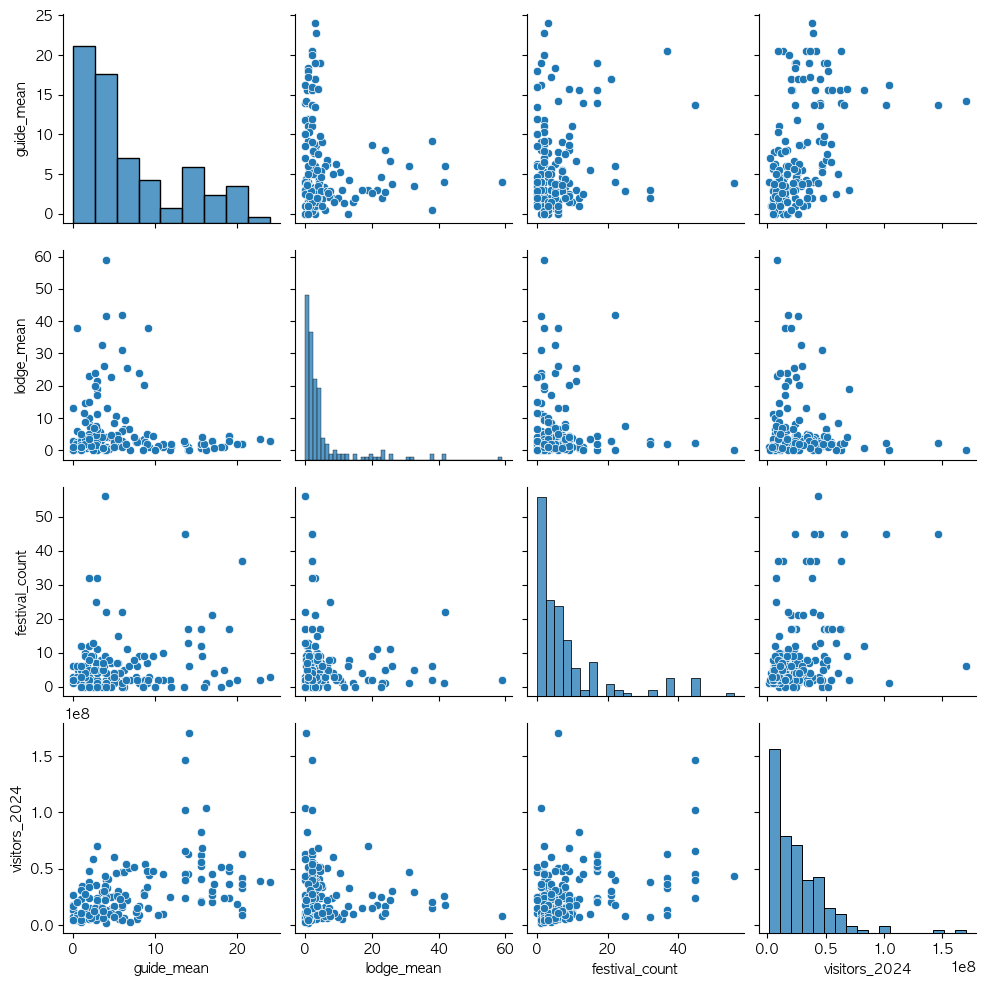

In [119]:
sns.pairplot(df_final[['guide_mean','lodge_mean','festival_count', 'visitors_2024']])

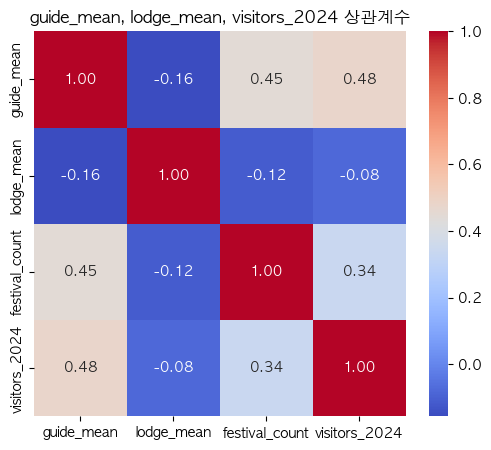

In [120]:
num_cols = ['guide_mean','lodge_mean','festival_count', 'visitors_2024']

corr = df_final[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("guide_mean, lodge_mean, visitors_2024 상관계수")
plt.show()

In [121]:
df_reg = df_final[['guide_mean','lodge_mean','festival_count', 'visitors_2024']].copy()
# infinite 값 제거(있진 않지만 습관적으로)
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
# NaN이 하나라도 있는 행 모두 제거
df_reg.dropna(inplace=True)

# 2) 분산 0인 변수 확인 (만약 하나라도 있다면 제거)
variances = df_reg.var()
print("분산:\n", variances)
zero_vars = variances[variances==0].index.tolist()
print("분산 0인 변수:", zero_vars)
df_reg.drop(columns=zero_vars, inplace=True)  # 빈 리스트면 변화 없음

# 3) X, y 재정의
X = df_reg.drop(columns=['visitors_2024'])
y = df_reg['visitors_2024']

# 4) 상수항 추가
Xc = sm.add_constant(X)

# 5) OLS 실행
model = sm.OLS(y, Xc).fit()
print(model.summary())

분산:
 guide_mean        3.937001e+01
lodge_mean        8.246007e+01
festival_count    1.270191e+02
visitors_2024     5.796344e+14
dtype: float64
분산 0인 변수: []
                            OLS Regression Results                            
Dep. Variable:          visitors_2024   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     18.50
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.96e-10
Time:                        15:37:22   Log-Likelihood:                -3179.2
No. Observations:                 174   AIC:                             6366.
Df Residuals:                     170   BIC:                             6379.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      

In [122]:
df_final['log_visitors'] = np.log1p(df_final['visitors_2024'])
df_final['log_guide'] = np.log1p(df_final['guide_mean'])
df_final['log_lodge'] = np.log1p(df_final['lodge_mean'])
df_final['log_festival'] = np.log1p(df_final['festival_count'])

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df_final[['yj_visitors','yj_guide','yj_lodge', 'yj_festival']] = pt.fit_transform(
    df_final[['visitors_2024','guide_mean','lodge_mean', 'festival_count']]
)

In [123]:
df_log = df_final[['log_guide','log_lodge','log_festival','log_visitors']].copy()
df_log = df_log.dropna(subset=['log_guide','log_lodge','log_festival','log_visitors'])

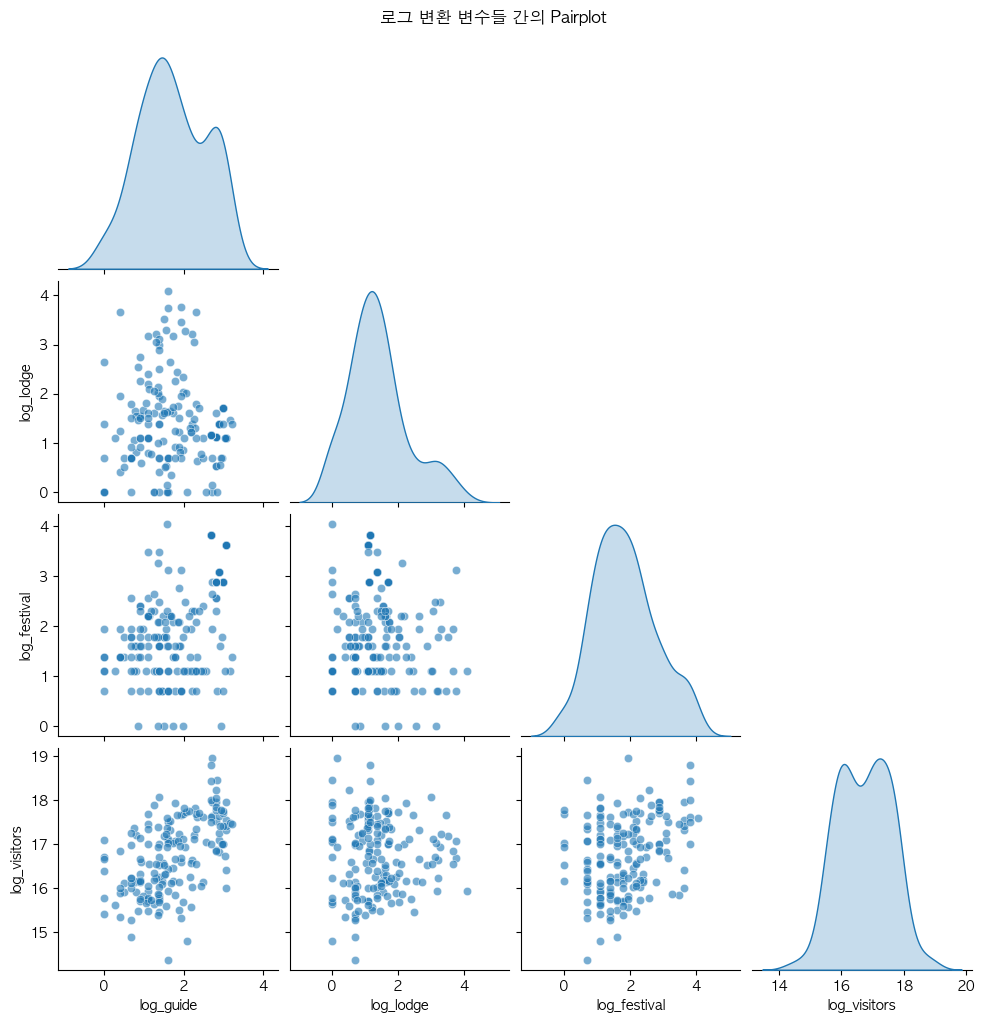

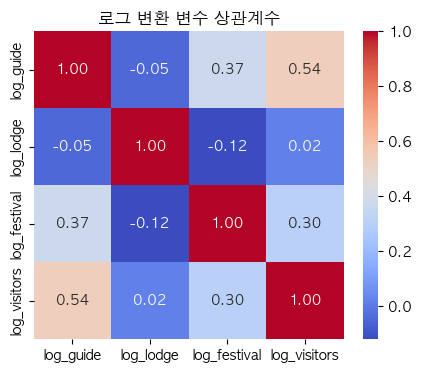

                            OLS Regression Results                            
Dep. Variable:           log_visitors   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     24.52
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           3.11e-13
Time:                        15:37:23   Log-Likelihood:                -187.13
No. Observations:                 174   AIC:                             382.3
Df Residuals:                     170   BIC:                             394.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.5771      0.175     89.125   

In [124]:
sns.pairplot(df_log,  
             diag_kind='kde', 
             corner=True,
             plot_kws={'alpha':0.6})
plt.suptitle("로그 변환 변수들 간의 Pairplot", y=1.02)
plt.show()

corr_log = df_log.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_log, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("로그 변환 변수 상관계수")
plt.show()

X = df_log[['log_guide','log_lodge', 'log_festival']]
y = df_log['log_visitors']
Xc = sm.add_constant(X)

model_log = sm.OLS(y, Xc).fit()
print(model_log.summary())

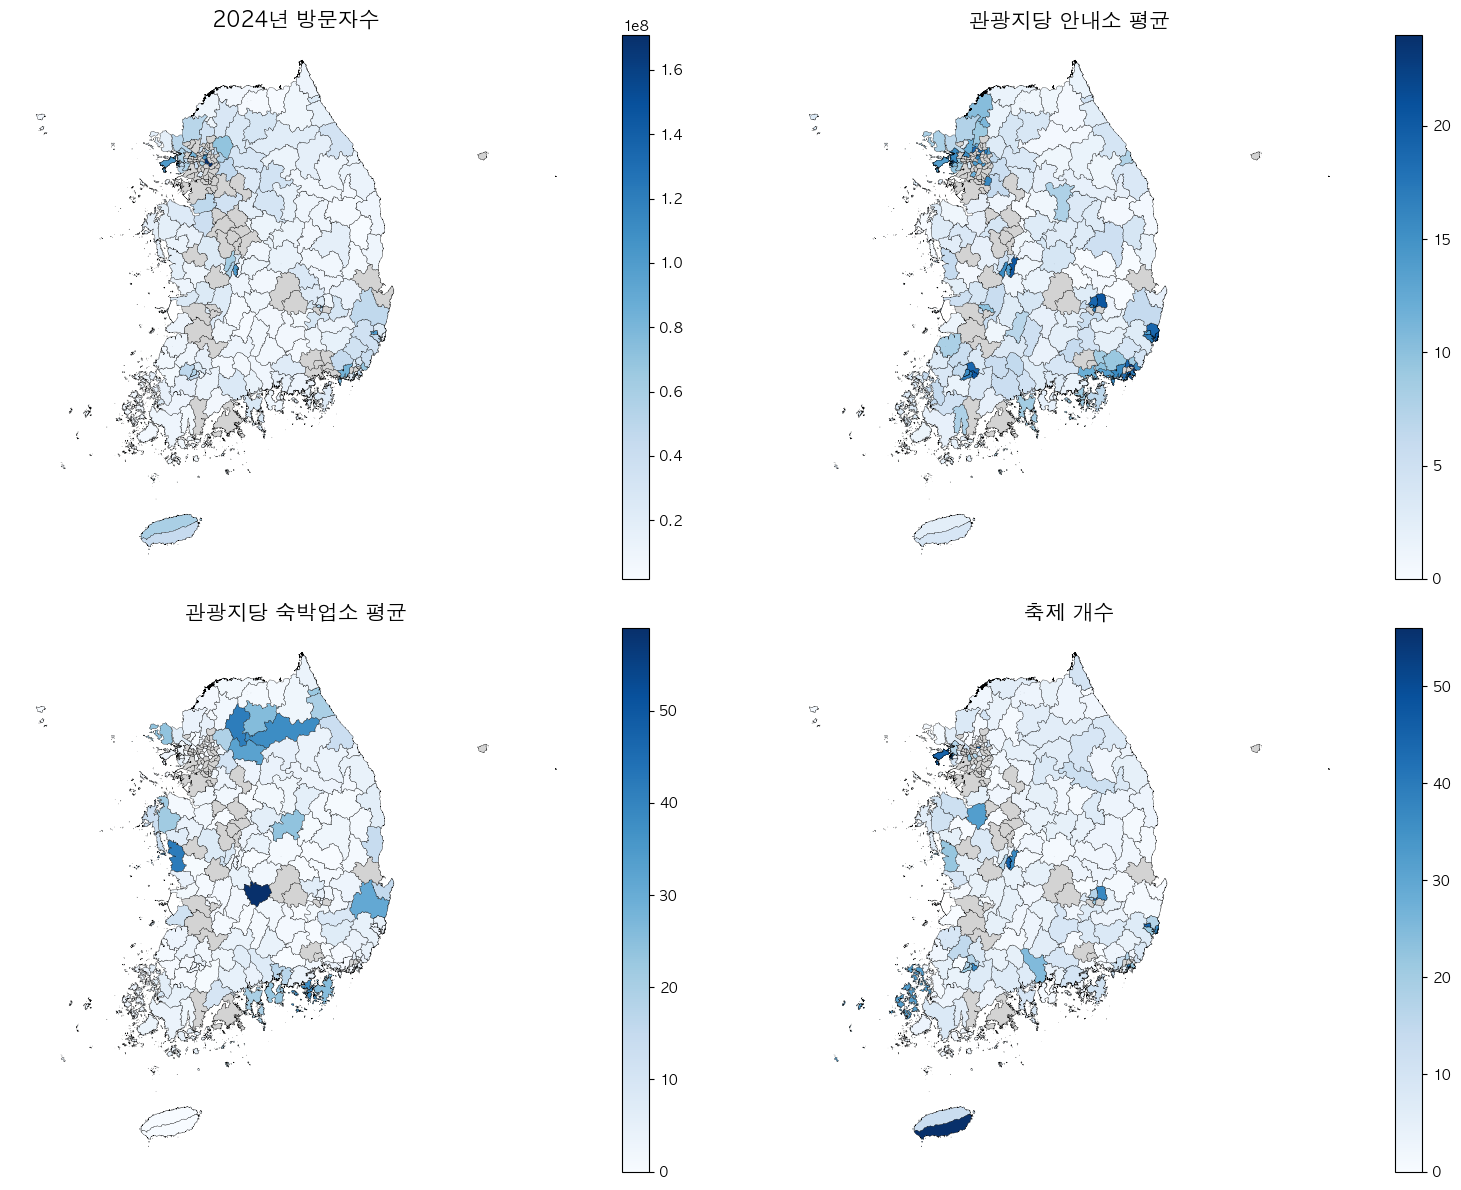

In [125]:
gdf_admin = gpd.read_file(shp_path, encoding='CP949')

gdf_map = gdf_admin.merge(
    df_final,
    left_on='SIG_KOR_NM',
    right_on='기초지자체명_매핑',
    how='left'
)

map_cols = [
    ('visitors_2024', '2024년 방문자수'),
    ('guide_mean',    '관광지당 안내소 평균'),
    ('lodge_mean',    '관광지당 숙박업소 평균'),
    ('festival_count','축제 개수')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (col, label) in enumerate(map_cols):
    gdf_map.plot(
        column=col,
        ax=axes[i],
        legend=True,
        cmap='Blues', 
        missing_kwds={'color': 'lightgrey'},
        edgecolor='black',
        linewidth=0.2
    )
    axes[i].set_title(label, fontsize=15)
    axes[i].axis('off')

plt.tight_layout()
plt.show()